In [ ]:
%pip install nbformat
%pip install imbalanced-learn
%pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nbformat

# Read your notebook (assuming version 4 for example purposes)
nb = nbformat.read("ml_project.ipynb", as_version=4)

# Normalize the notebook to add missing id fields and other updates
nbformat.validator.validate(nb)

# Write the normalized notebook back to a file
nbformat.write(nb, "ml_project_normalized.ipynb")

In [ ]:
%run ml_project_normalized.ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Unique primary colors:
 1. black
 2. non-black
dropped columns
cleaned intake time
cleaned intake condition
cleaned age and sex
Unique primary colors:
 1. black
 2. non-black
cleaned color
cleaned breed
dropped columns


/tmp/ipykernel_1036474/1199118304.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt_series = pd.to_datetime(df['intake_time'], errors='coerce')


cleaned intake time
cleaned intake condition
cleaned age and sex
Unique primary colors:
 1. black
 2. non-black
cleaned color
cleaned breed
Done running ml_project.ipynb.


In [30]:
import numpy as np
np.float = float  # Patch for libraries using deprecated np.float


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import numpy as np
import pandas as pd

def train_classifier_lightgbm(
    X_train, y_train, X_test, rare_classes, cat_cols, custom_thresholds=None
):
    """
    Trains a LightGBM model using hyperparameter tuning.
    Applies custom thresholding during prediction if specified and compares standard vs. custom accuracy.

    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series or np.array): Training target values.
        X_test (pd.DataFrame): Test features.
        rare_classes (list): List of integer-encoded classes to be oversampled.
        cat_cols (set or list): Categorical columns to one-hot encode.
        custom_thresholds (dict, optional): Dict of class_label -> threshold.
            e.g., {0: 0.7, 1: 0.5, 2: 0.5} for class 0 = supermajority.

    Returns:
        best_estimator: Trained pipeline.
        test_predictions: Custom-thresholded predictions.
        df_importances: Feature importances from LightGBM.
    """
    # Compute balanced sample weights
    class_labels = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
    class_weight_dict = dict(zip(class_labels, class_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])

    # Ensure categorical features are strings
    categorical_features = [col for col in X_train.columns if col in cat_cols]
    for col in categorical_features:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)

    # Define preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )

    # Build pipeline with LightGBM classifier
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("lgbm", LGBMClassifier(objective='multiclass', verbosity=-1))
    ])

    # Hyperparameter search space for LGBM
    param_distributions = {
        "lgbm__num_leaves": randint(20, 150),
        "lgbm__learning_rate": uniform(0.01, 0.5),
        "lgbm__n_estimators": randint(50, 500),
    "lgbm__subsample":        uniform(0.3, 0.7),
    "lgbm__colsample_bytree": uniform(0.3, 0.7),
        "lgbm__min_child_samples": randint(1, 50),
        "lgbm__min_split_gain": uniform(0, 1.0),
        "lgbm__reg_alpha": uniform(0, 1.0),
        "lgbm__reg_lambda": uniform(0.5, 2.5)
    }

    # Stratified cross-validation setup
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Randomized search for best hyperparameters
    randomized_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_iter=5,
        cv=stratified_cv,
        scoring='balanced_accuracy',
        verbose=3,
        random_state=42
    )

    print(f"\n[INFO] Starting training with {len(X_train)} samples and {len(y_train)} labels")
    randomized_search.fit(X_train, y_train, **{'lgbm__sample_weight': sample_weights})
    print(f"[INFO] Training complete. Best model fitted on {len(X_train)} samples.\n")

    # Inspect transformed features
    best_preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
    encoded_X_train = best_preprocessor.transform(X_train)
    if hasattr(encoded_X_train, "toarray"):
        encoded_X_train = encoded_X_train.toarray()
    feature_names = best_preprocessor.get_feature_names_out()
    print("Sample of transformed training features:")
    print(pd.DataFrame(encoded_X_train, columns=feature_names).head())

    # Print best parameters and CV score
    print('Best parameters:', randomized_search.best_params_)
    print('Best cross-validation balanced accuracy:', randomized_search.best_score_)

    # Generalization accuracy via cross_val_score
    cv_scores = cross_val_score(
        randomized_search.best_estimator_,
        X_train,
        y_train,
        cv=5,
        verbose=3,
        scoring='balanced_accuracy'
    )
    print('Generalization balanced accuracy:', cv_scores.mean())

    # Prediction with optional custom thresholds
    lgbm_model = randomized_search.best_estimator_.named_steps['lgbm']
    class_names = lgbm_model.classes_

    def apply_custom_thresholds(probabilities, class_names, thresholds_dict):
        thresholds = np.array([thresholds_dict.get(cls, 0.5) for cls in class_names])
        preds = []
        for row in probabilities:
            passed = row >= thresholds
            if not passed.any():
                pred = class_names[np.argmax(row)]
            else:
                pred = class_names[np.argmax(passed * row)]
            preds.append(pred)
        return np.array(preds)

    proba_test = randomized_search.predict_proba(X_test)
    if custom_thresholds:
        print("[INFO] Applying custom threshold logic to test set")
        test_predictions = apply_custom_thresholds(proba_test, class_names, custom_thresholds)
    else:
        test_predictions = randomized_search.predict(X_test)

    # Compare accuracies on training set if custom thresholds provided
    if custom_thresholds:
        proba_train = randomized_search.predict_proba(X_train)
        preds_custom_train = apply_custom_thresholds(proba_train, class_names, custom_thresholds)
        acc_standard = accuracy_score(y_train, randomized_search.predict(X_train))
        acc_custom = accuracy_score(y_train, preds_custom_train)
        bal_acc_standard = balanced_accuracy_score(y_train, randomized_search.predict(X_train))
        bal_acc_custom = balanced_accuracy_score(y_train, preds_custom_train)

        print(f"\nAccuracy Comparison on Training Set:")
        print(f"Standard Accuracy: {acc_standard:.4f}")
        print(f"Custom Threshold Accuracy: {acc_custom:.4f}")
        print(f"Standard Balanced Accuracy: {bal_acc_standard:.4f}")
        print(f"Custom Threshold Balanced Accuracy: {bal_acc_custom:.4f}")

    # Extract feature importances
    importances = lgbm_model.feature_importances_
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

    return randomized_search.best_estimator_, test_predictions, df_importances


In [ ]:
def add_in_austin(df, df_loc):
    """
    Adds a binary column 'in_austin' that is 1 if 'austin' appears
    (case‑insensitive) in the 'location' field, else 0.
    """
    df['in_austin'] = (
        df_loc
        .str.contains('austin', case=False, na=False)
        .astype(int)
    )
    return df

In [ ]:
'''
X_train = df_train.copy()
#X_train = add_in_austin(X_train, df_train_location)
print(X_train['breed'].unique())
X_train = bucket_seasons(X_train)
X_train = bucket_days(X_train)
X_train = X_train.drop(columns=['intake_month', 'intake_hour'])
'''

"\nX_train = df_train.copy()\n#X_train = add_in_austin(X_train, df_train_location)\nprint(X_train['breed'].unique())\nX_train = bucket_seasons(X_train)\nX_train = bucket_days(X_train)\nX_train = X_train.drop(columns=['intake_month', 'intake_hour'])\n"

In [ ]:
'''
X_test = df_test.copy()
#X_test = add_in_austin(X_test, df_test_location)
X_test = bucket_seasons(X_test)
X_test = bucket_days(X_test)
X_test = X_test.drop(columns=['intake_month', 'intake_hour'])
X_test.head()
'''

"\nX_test = df_test.copy()\n#X_test = add_in_austin(X_test, df_test_location)\nX_test = bucket_seasons(X_test)\nX_test = bucket_days(X_test)\nX_test = X_test.drop(columns=['intake_month', 'intake_hour'])\nX_test.head()\n"

In [ ]:
df_train.head()

,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,intake_year,intake_month,intake_hour,primary_color,is_mix,size,outcome_type
0,Stray,Normal / Behavior,Dog,Spayed Female,96.0,2,2015,7,12,non-black,0,3,Return to Owner
1,Stray,Normal / Behavior,Dog,Intact Male,11.0,7,2016,4,18,non-black,1,2,Return to Owner
2,Public Assist,Normal / Behavior,Cat,Neutered Male,24.0,Common,2022,5,0,non-black,0,2,Transfer
3,Owner Surrender,Normal / Behavior,Dog,Neutered Male,24.0,2,2017,2,12,non-black,1,4,Return to Owner
4,Public Assist,Normal / Behavior,Dog,Neutered Male,72.0,3,2019,4,9,black,1,5,Return to Owner


In [36]:
X = df_train.drop(columns=['outcome_type'])
y = df_train['outcome_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

# Encode the target variable.
le = LabelEncoder()
#y_train = X_train['outcome_type']
#X_train = X_train.drop(columns=['outcome_type'])
y_train = le.fit_transform(y_train)
print('Encoding mapping:', le.classes_)

# Identify rare classes that need oversampling.
rare_classes = [
    label for label, count in pd.Series(y_train).value_counts().items()
    if count < 0.05 * len(y_train)
]
print("Rare classes:")
for cls in rare_classes:
    print(f"  {cls}: {le.classes_[cls]}")

# Define column groups (this example will one-hot encode all columns, so cat_cols and num_cols are not used in the transformer).
cat_cols = {'intake_type', 'intake_condition', 'animal_type', 'sex_upon_intake', 'breed', 'intake_month', 'intake_hour', 'intake_year', 'season', 'time_of_day'}
categorical_features = [col for col in X_train.columns if col in cat_cols]

'''
# cat_cols_freq = ['primary_color']

# Frequency encode selected high-cardinality features
# for col in cat_cols_freq:
#   freq_map = X_train[col].value_counts()
#   X_train[col] = X_train[col].map(freq_map)
#   X_test[col]  = X_test[col].map(freq_map).fillna(0)
'''
# Train the classifier with the refactored pipeline.

custom_thresholds = {
    0: 0.6,
    1: 0.5,
    2: 0.5,
    3: 0.5,
    4: 0.5
}

best_model, test_predictions, df_importances = train_classifier_lightgbm(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    rare_classes=rare_classes,
    cat_cols=categorical_features,
    custom_thresholds=custom_thresholds
)

# Convert predictions back to original labels.
predictions = le.inverse_transform(test_predictions)

# Save predictions; assumes save_predictions is defined elsewhere.
classification_report_with_accuracy_score(y_test, predictions)
#save_predictions(predictions, 'lightgbm')

Encoding mapping: ['Adoption' 'Died' 'Euthanasia' 'Return to Owner' 'Transfer']
Rare classes:
  2: Euthanasia
  1: Died

[INFO] Starting training with 88924 samples and 88924 labels
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END lgbm__colsample_bytree=0.5621780831931538, lgbm__learning_rate=0.4853571532049581, lgbm__min_child_samples=43, lgbm__min_split_gain=0.7796910002727693, lgbm__n_estimators=70, lgbm__num_leaves=122, lgbm__reg_alpha=0.44583275285359114, lgbm__reg_lambda=0.7499372895450072, lgbm__subsample=0.621474224376107;, score=nan total time=   0.3s
[CV 2/5] END lgbm__colsample_bytree=0.5621780831931538, lgbm__learning_rate=0.4853571532049581, lgbm__min_child_samples=43, lgbm__min_split_gain=0.7796910002727693, lgbm__n_estimators=70, lgbm__num_leaves=122, lgbm__reg_alpha=0.44583275285359114, lgbm__reg_lambda=0.7499372895450072, lgbm__subsample=0.621474224376107;, score=nan total time=   0.2s
[CV 3/5] END lgbm__colsample_bytree=0.5621780831931538, lgbm

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/u/nneoma/.local/lib/python3.8/site-packages/imblearn/pipeline.py", line 333, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "/u/nneoma/.local/lib/python3.8/site-packages/lightgbm/sklearn.py", line 1560, in fit
    super().fit(
  File "/u/nneoma/.local/lib/python3.8/site-packages/lightgbm/sklearn.py", line 949, in fit
    _X, _y = _LGBMValidateData(
  File "/u/nneoma/.local/lib/python3.8/site-packages/lightgbm/compat.py", line 78, in validate_data
    X, y = check_X_y(
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 1146, in check_X_y
    X = check_array(
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/utils/validation.py", line 915, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/u/nneoma/.local/lib/python3.8/site-packages/sklearn/utils/_array_api.py", line 380, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'non-black'


[CV 1/5] END lgbm__colsample_bytree=0.5621780831931538, lgbm__learning_rate=0.4853571532049581, lgbm__min_child_samples=43, lgbm__min_split_gain=0.7796910002727693, lgbm__n_estimators=70, lgbm__num_leaves=122, lgbm__reg_alpha=0.44583275285359114, lgbm__reg_lambda=0.7499372895450072, lgbm__subsample=0.621474224376107;, score=0.533 total time=   1.6s
[CV 2/5] END lgbm__colsample_bytree=0.5621780831931538, lgbm__learning_rate=0.4853571532049581, lgbm__min_child_samples=43, lgbm__min_split_gain=0.7796910002727693, lgbm__n_estimators=70, lgbm__num_leaves=122, lgbm__reg_alpha=0.44583275285359114, lgbm__reg_lambda=0.7499372895450072, lgbm__subsample=0.621474224376107;, score=0.518 total time=   1.6s
[CV 3/5] END lgbm__colsample_bytree=0.5621780831931538, lgbm__learning_rate=0.4853571532049581, lgbm__min_child_samples=43, lgbm__min_split_gain=0.7796910002727693, lgbm__n_estimators=70, lgbm__num_leaves=122, lgbm__reg_alpha=0.44583275285359114, lgbm__reg_lambda=0.7499372895450072, lgbm__subsampl

KeyboardInterrupt: 

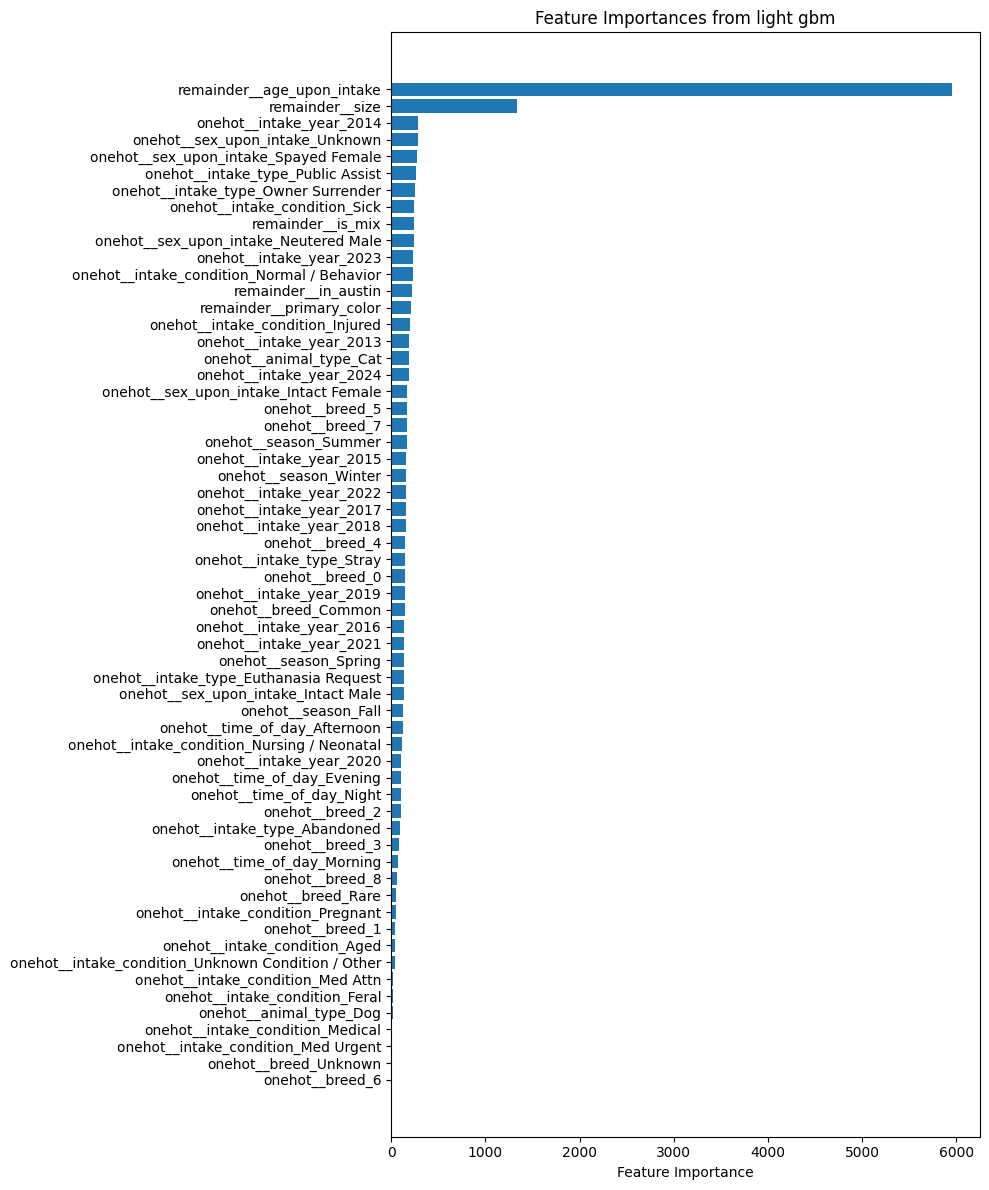

In [ ]:
import matplotlib.pyplot as plt

df_plot = df_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10, 12))
plt.barh(df_plot['feature'], df_plot['importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from light gbm')
plt.tight_layout()
plt.show()